In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from umap import UMAP
from hdbscan import HDBSCAN

Fetch the data from OpenML.org (unless there is a local, cached version present).

In [3]:
data = fetch_openml("mnist_784", version=1)
X = data['data']
N, D = X.shape
y = data['target']

Always plot a test sample.

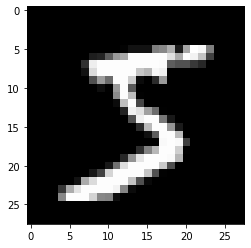

In [4]:
fig, ax = plt.subplots(1,1)
ax.imshow(X[0].reshape((28,28)), cmap='gray')
plt.show()

Compute some simple metrics to get a feel for the distribution of values:

In [5]:
print("Min    : ", np.min(X))
print("Mean   : ", np.mean(X))
print("Median : ", np.median(X))
print("Max    : ", np.max(X))

Min    :  0.0
Mean   :  33.385964741253645
Median :  0.0
Max    :  255.0


A plot of the distribution of values can be even more informative:

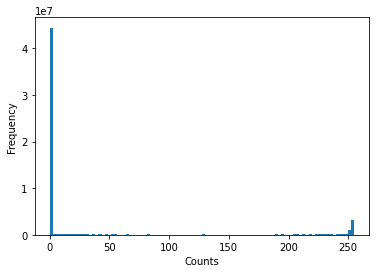

In [6]:
fig, ax = plt.subplots(1,1)
ax.hist(X.ravel(), bins=100)
ax.set_xlabel('Counts')
ax.set_ylabel('Frequency')
plt.show()

Dimensionality reduction using PCA:

In [8]:
pca_instance = PCA()
pca_instance.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Determine cutoff using a scree plot; keep dimensions that explain 90% of the variance.

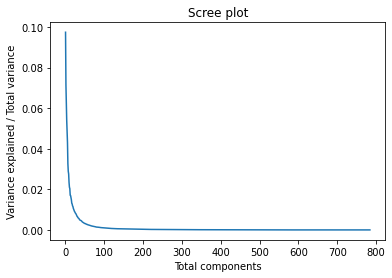

In [9]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(1, D+1), pca_instance.explained_variance_ratio_)
ax.set_xlabel('Total components')
ax.set_ylabel('Variance explained / Total variance')
ax.set_title('Scree plot')
plt.show()

In [41]:
d = np.where(np.cumsum(pca_instance.explained_variance_ratio_) > 0.90)[0][0]
print("New dimensionality is:", d)

New dimensionality is: 86


Transform data to lower dimensional representation using PCA.

In [42]:
pca_transformed = PCA(n_components=d, whiten=False).fit_transform(X)

Inspect the separation of classes in the plane spanned by the first two components:

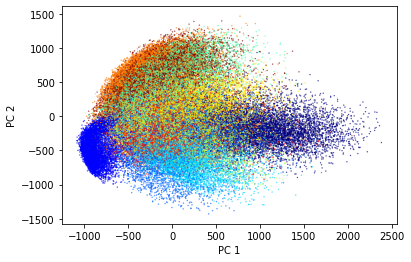

In [43]:
fig, ax = plt.subplots(1,1)
ax.scatter(pca_transformed[:,0], pca_transformed[:,1], c=y.astype(np.int), s=0.1, cmap='jet')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()

Further dimensionality reduction using UMAP:

In [44]:
umap_instance = UMAP(n_components=2)
umap_transformed = umap_instance.fit_transform(pca_transformed)

/home/paul/.virtualenvs/base3/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".virtualenvs/base3/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


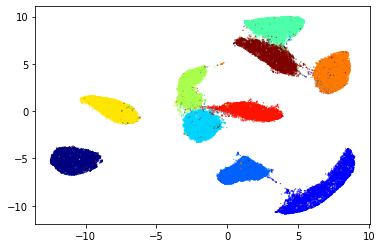

In [45]:
fig, ax = plt.subplots(1,1)
ax.scatter(umap_transformed[:,0], umap_transformed[:,1], c=y.astype(np.int), s=0.1, cmap='jet') 
plt.show()

Clustering using HDBSCAN:

In [46]:
hdbscan_instance = HDBSCAN(min_samples=10, min_cluster_size=500)
y_predicted = hdbscan_instance.fit_predict(umap_transformed)

Plot predictions:

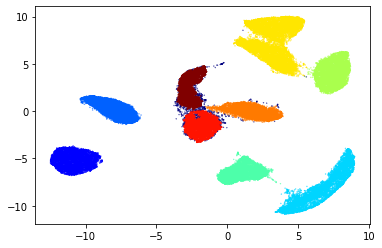

In [47]:
fig, ax = plt.subplots(1,1)
ax.scatter(umap_transformed[:,0], umap_transformed[:,1], c=y_predicted.astype(np.int), s=0.1, cmap='jet') 
plt.show()

The cluster in the upper right seems to be underclustered. There are several possible strategies to address this issue.

- Subselect the data and rerun the clustering on the selection to force a partition.  This would work well with a partitioning algorithm, less so with HDBSCAN.
- Change the parameters of HDBSCAN until we get the desired result. 
- Change the input to HDBSCAN by changing the PCA and/or UMAP transformation.